In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Exploratory data anaylysis

In [4]:
df.shape

(303, 14)

Checking for NAN values

In [5]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Checking for outliers

In [7]:
columns = ['age','trestbps','chol','oldpeak']

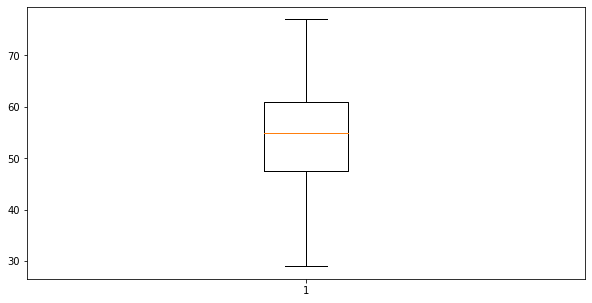

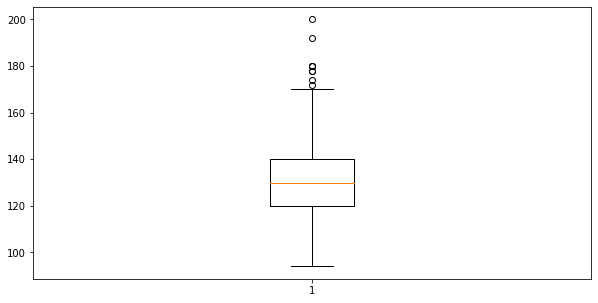

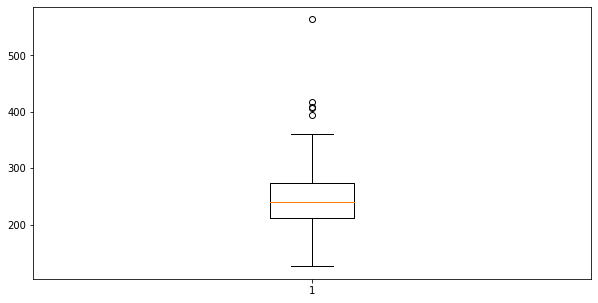

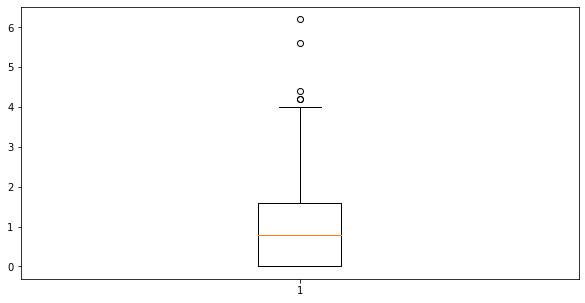

In [8]:
for i in range(0,len(columns)):
  fig = plt.figure(figsize=(10,5))
  plt.boxplot(x=df[columns[i]])

## Plotting histogram to chcek the skewness of variable

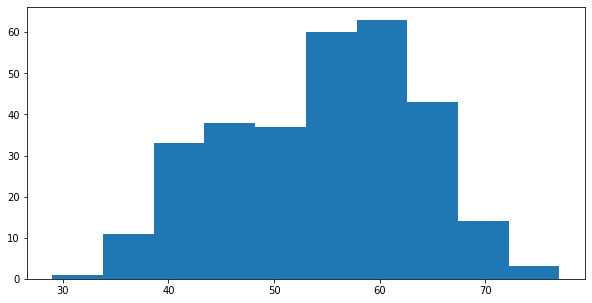

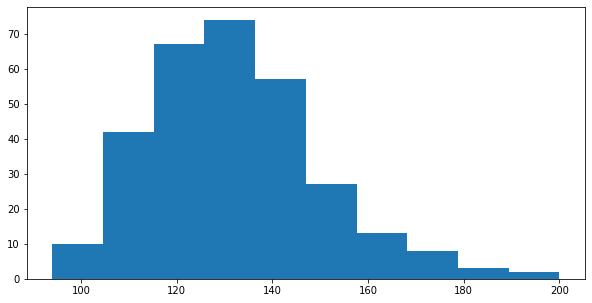

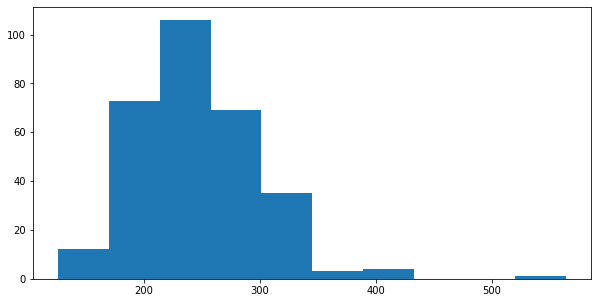

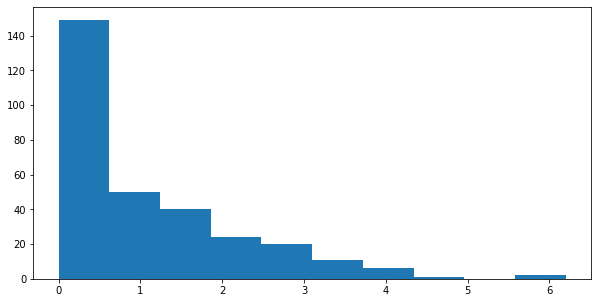

In [9]:
for i in range(0,len(columns)):
    fig = plt.figure(figsize=(10,5))
    plt.hist(x=df[columns[i]])

# Using IQR technique to impute outliers

In [10]:
columns = ['trestbps','chol','oldpeak']

In [11]:
for i in df[columns]:
    quantile1, quantile3= np.percentile(df[i],[25,75])
    iqr_value=quantile3-quantile1
    print(i,'; quantile1',quantile1,'; quantile3',quantile3,'; IQR',iqr_value)
    lower_bound_val = quantile1 -(1.7 * iqr_value)
    upper_bound_val = quantile3 +(1.7 * iqr_value)
    df.loc[df[i]>=upper_bound_val,i]=df[i].mean()
    df.loc[df[i]<=lower_bound_val,i]=df[i].mean()
    print('--------------------------------------------------------------------------------------------------')

trestbps ; quantile1 120.0 ; quantile3 140.0 ; IQR 20.0
--------------------------------------------------------------------------------------------------
chol ; quantile1 211.0 ; quantile3 274.5 ; IQR 63.5
--------------------------------------------------------------------------------------------------
oldpeak ; quantile1 0.0 ; quantile3 1.6 ; IQR 1.6
--------------------------------------------------------------------------------------------------


## Feature selection

## Finding correlation

In [12]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

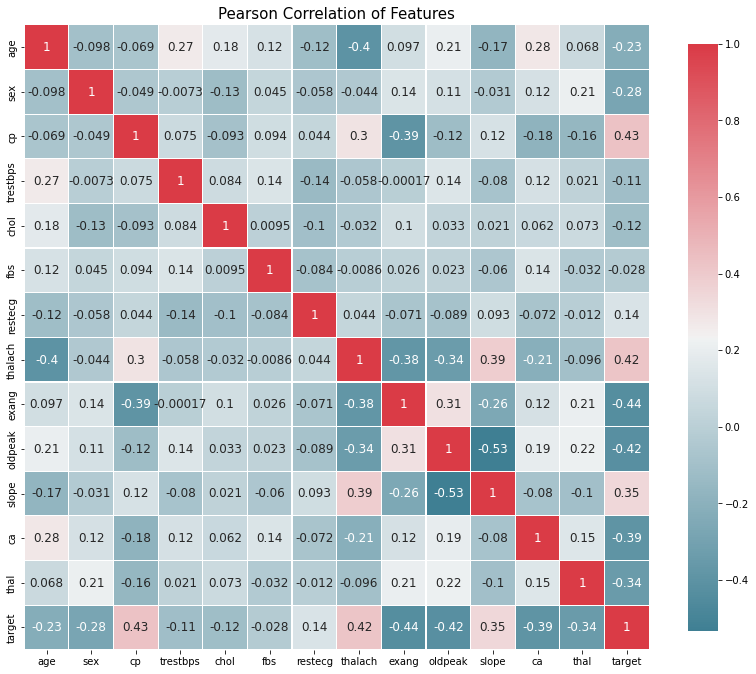

In [13]:
correlation_heatmap(df)

# Checking the correlation with target column

In [14]:
df_corr = df.copy()

In [15]:
abs(df_corr.corr()['target']).sort_values(ascending=False)

target      1.000000
exang       0.436757
cp          0.433798
oldpeak     0.421896
thalach     0.421741
ca          0.391724
slope       0.345877
thal        0.344029
sex         0.280937
age         0.225439
restecg     0.137230
chol        0.115652
trestbps    0.110449
fbs         0.028046
Name: target, dtype: float64

# Checking feature importance with Random forest

In [16]:
df_fs = df.copy()

In [17]:
X = df_fs.drop(['target'], axis=1)
y = df_fs['target']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [20]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
dict(reversed(sorted(zip(rf.feature_importances_, X.columns.values))))

{0.008859172572122313: 'fbs',
 0.018985997946306125: 'restecg',
 0.027419141412848392: 'sex',
 0.06487405087530014: 'slope',
 0.07157942965760583: 'exang',
 0.07160493542986704: 'age',
 0.07183963265706438: 'ca',
 0.07305230111061631: 'trestbps',
 0.07801791017775564: 'chol',
 0.10542441914821413: 'oldpeak',
 0.11534616434451495: 'thal',
 0.12635487587023428: 'thalach',
 0.16664196879755025: 'cp'}

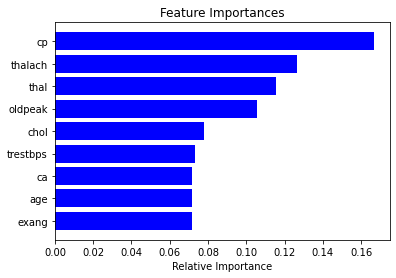

In [22]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-9:] 
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We observe **cp**(Chest-pain type : displays the type of chest-pain experienced by the individual using the following format), **oldpeak**(ST depression induced by exercise relative to rest), **thalach**(maximum heart rate achieved) and **ca**(Number of major vessels (0-3) colored by flourosopy : displays the value as integer or float) are some of important features that we get by using both Random forest classifier and correlation

# Normalizing the data

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
minmax = MinMaxScaler()

In [24]:
X = df.drop(['target'], axis=1)
y = df['target']

# Using Standard Scaler for Classification algorithms (Random forest & Naive Bayes)

In [25]:
df_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [26]:
df_scaled.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.952197,0.681005,1.973123,0.962687,-0.226142,2.394438,-1.005832,0.015443,-0.696631,1.216648,-2.274579,-0.714429,-2.148873
1,-1.915313,0.681005,1.002577,-0.017905,0.154615,-0.417635,0.898962,1.633471,-0.696631,2.336633,-2.274579,-0.714429,-0.512922
2,-1.474158,-1.468418,0.032031,-0.017905,-0.875670,-0.417635,-1.005832,0.977514,-0.696631,0.376659,0.976352,-0.714429,-0.512922
3,0.180175,0.681005,0.032031,-0.671633,-0.158950,-0.417635,0.898962,1.239897,-0.696631,-0.183334,0.976352,-0.714429,-0.512922
4,0.290464,-1.468418,-0.938515,-0.671633,2.483955,-0.417635,0.898962,0.583939,1.435481,-0.369998,0.976352,-0.714429,-0.512922


# Using MinMax Scaler for Neural Network (LSTM)

In [27]:
df_scaled_minmax = pd.DataFrame(minmax.fit_transform(X), columns=X.columns)

In [28]:
df_scaled_minmax.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.708333,1.0,1.000000,0.653846,0.457265,1.0,0.0,0.603053,0.0,0.547619,0.0,0.0,0.333333
1,0.166667,1.0,0.666667,0.461538,0.529915,0.0,0.5,0.885496,0.0,0.833333,0.0,0.0,0.666667
2,0.250000,0.0,0.333333,0.461538,0.333333,0.0,0.0,0.770992,0.0,0.333333,1.0,0.0,0.666667
3,0.562500,1.0,0.333333,0.333333,0.470085,0.0,0.5,0.816794,0.0,0.190476,1.0,0.0,0.666667
4,0.583333,0.0,0.000000,0.333333,0.974359,0.0,0.5,0.702290,1.0,0.142857,1.0,0.0,0.666667


# Function to calculate evalution metrics

In [29]:
def classification_metrics(cnf_matrix):
  FN = cnf_matrix[1,0]
  FP = cnf_matrix[0,1]
  TP = cnf_matrix[0,0]
  TN = cnf_matrix[1,1]
  P = TP + FN 
  N = TN + FP
  TPR = TP/P
  TNR = TN/N
  FPR = FP/N
  FNR = FN/P
  SPC = TN / (FP + TN)
  r = TP/P
  p = TP/(TP + FP)
  F1 = 2 * (p * r)/(p + r)
  err = (FP + FN)/(P + N)
  acc = (TP + TN) / (P + N)
  bacc = (TPR + TNR) / 2
  tss = (TP / (TP + FN)) - (FP / (FP + TN))
  hss = (2*(TP * TN - FP * FN)) / (((TP + FN) * (FN + TN)) + ((TP + FP) * (FP + TN)))
  dictionary = {'False negative':FN, 'False positive': FP, 'True positive': TP, 'True negative': TN,
              'True positive rate': TPR, 'True negative rate': TNR, 'False positive rate': FPR, 'False negative rate': FNR, 
              'Specificity': SPC, 'Recall': r, 'Precision': p, 'F1 measure': F1, 'Error rate': err, 
              'Accuracy': acc, 'Balanced Accuracy': bacc, 'True Skill Statistics': tss, 'Heidke Skill Score': hss
              }
  res = pd.DataFrame([dictionary])       
  return res

## Building models

In [30]:
X = df_scaled
X_minmax = df_scaled_minmax
y = df['target']

Random Forest

************************************************************************************************************************************************************************
kFold : 1
Accuracy for Random Forest : 82.42
Confusion matrix:
[[30 11]
 [ 5 45]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,5,11,30,45,0.857143,0.803571,0.196429,0.142857,0.803571,0.857143,0.731707,0.789474,0.175824,0.824176,0.830357,0.660714,0.640138


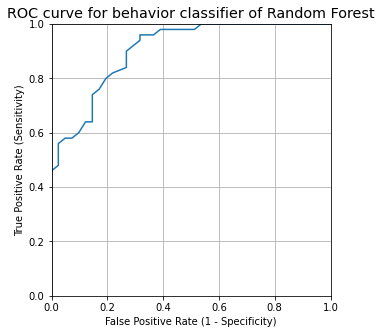


Naive Bayes

************************************************************************************************************************************************************************
kFold : 1
Accuracy for Naive Bayes : 81.32
Confusion matrix:
[[31 10]
 [ 7 43]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,7,10,31,43,0.815789,0.811321,0.188679,0.184211,0.811321,0.815789,0.756098,0.78481,0.186813,0.813187,0.813555,0.62711,0.620182


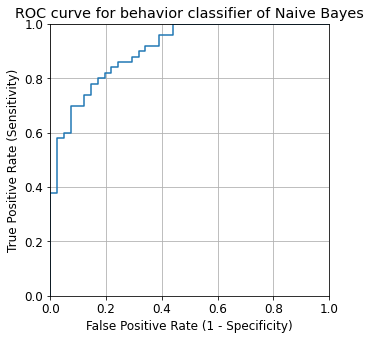


LSTM

************************************************************************************************************************************************************************
Epoch 1/5
7/7 [==============================] - 4s 15ms/step - loss: 0.8563 - accuracy: 0.5425 - auc: 0.5000
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.7013 - accuracy: 0.5425 - auc: 0.5000
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.6893 - accuracy: 0.5425 - auc: 0.5000
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.6969 - accuracy: 0.5425 - auc: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 15ms/step - loss: 0.7266 - accuracy: 0.5425 - auc: 0.5000
Test Accuracy for LSTM:
3/3 [==============================] - 1s 8ms/step - loss: 0.7159 - accuracy: 0.5495 - auc: 0.5000
[[ 0 41]
 [ 0 50]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,0,41,0,50,NaN,0.549451,0.450549,NaN,0.549451,NaN,0.0,NaN,0.450549,0.549451,NaN,NaN,0.0


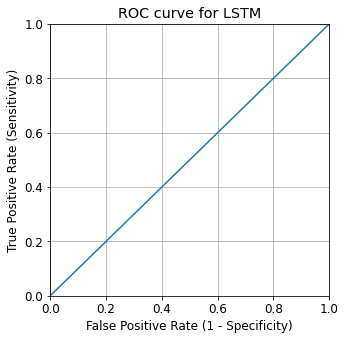

------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest

************************************************************************************************************************************************************************
kFold : 2
Accuracy for Random Forest : 79.12
Confusion matrix:
[[28 13]
 [ 6 44]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,6,13,28,44,0.823529,0.77193,0.22807,0.176471,0.77193,0.823529,0.682927,0.746667,0.208791,0.791209,0.79773,0.595459,0.571712


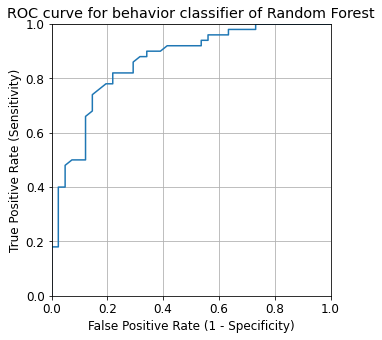


Naive Bayes

************************************************************************************************************************************************************************
kFold : 2
Accuracy for Naive Bayes : 74.73
Confusion matrix:
[[26 15]
 [ 8 42]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,8,15,26,42,0.764706,0.736842,0.263158,0.235294,0.736842,0.764706,0.634146,0.693333,0.252747,0.747253,0.750774,0.501548,0.481546


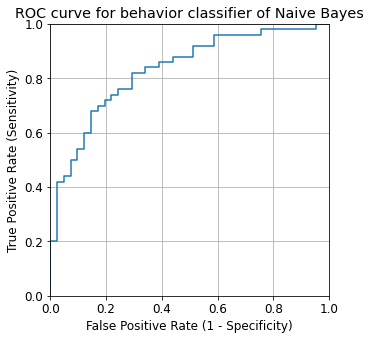


LSTM

************************************************************************************************************************************************************************
Epoch 1/5
7/7 [==============================] - 4s 15ms/step - loss: 0.9173 - accuracy: 0.5425 - auc_1: 0.5000
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.7287 - accuracy: 0.5425 - auc_1: 0.5000
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.7302 - accuracy: 0.5425 - auc_1: 0.5000
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.6579 - accuracy: 0.5425 - auc_1: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.6362 - accuracy: 0.5425 - auc_1: 0.5000
Test Accuracy for LSTM:
3/3 [==============================] - 1s 7ms/step - loss: 0.5970 - accuracy: 0.5495 - auc_1: 0.5000
[[ 0 41]
 [ 0 50]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,0,41,0,50,NaN,0.549451,0.450549,NaN,0.549451,NaN,0.0,NaN,0.450549,0.549451,NaN,NaN,0.0


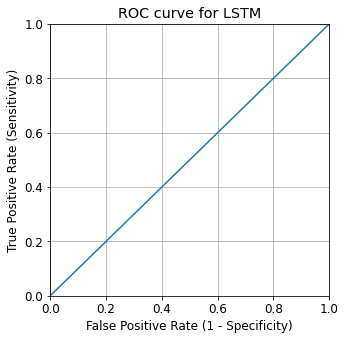

------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest

************************************************************************************************************************************************************************
kFold : 3
Accuracy for Random Forest : 84.62
Confusion matrix:
[[30 11]
 [ 3 47]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,3,11,30,47,0.909091,0.810345,0.189655,0.090909,0.810345,0.909091,0.731707,0.810811,0.153846,0.846154,0.859718,0.719436,0.683714


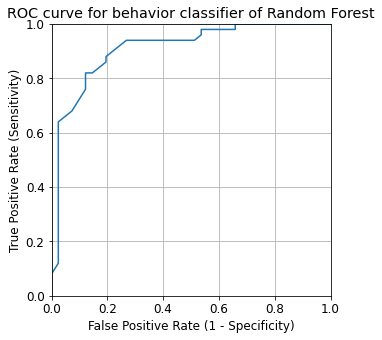


Naive Bayes

************************************************************************************************************************************************************************
kFold : 3
Accuracy for Naive Bayes : 85.71
Confusion matrix:
[[33  8]
 [ 5 45]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,5,8,33,45,0.868421,0.849057,0.150943,0.131579,0.849057,0.868421,0.804878,0.835443,0.142857,0.857143,0.858739,0.717478,0.709551


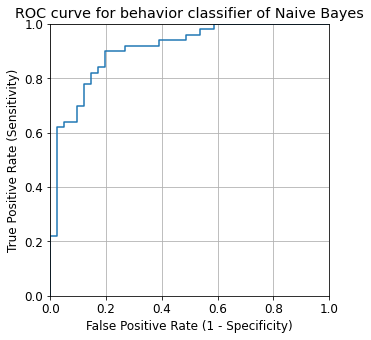


LSTM

************************************************************************************************************************************************************************
Epoch 1/5
7/7 [==============================] - 4s 15ms/step - loss: 0.8164 - accuracy: 0.5425 - auc_2: 0.5000
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.7037 - accuracy: 0.5425 - auc_2: 0.5000
Epoch 3/5
7/7 [==============================] - 0s 15ms/step - loss: 0.6917 - accuracy: 0.5425 - auc_2: 0.5000
Epoch 4/5
7/7 [==============================] - 0s 15ms/step - loss: 0.6918 - accuracy: 0.5425 - auc_2: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 15ms/step - loss: 0.6952 - accuracy: 0.5425 - auc_2: 0.5000
Test Accuracy for LSTM:
3/3 [==============================] - 1s 7ms/step - loss: 0.6883 - accuracy: 0.5495 - auc_2: 0.5000
[[ 0 41]
 [ 0 50]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,0,41,0,50,NaN,0.549451,0.450549,NaN,0.549451,NaN,0.0,NaN,0.450549,0.549451,NaN,NaN,0.0


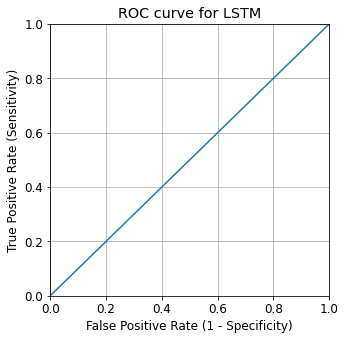

------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest

************************************************************************************************************************************************************************
kFold : 4
Accuracy for Random Forest : 79.12
Confusion matrix:
[[28 13]
 [ 6 44]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,6,13,28,44,0.823529,0.77193,0.22807,0.176471,0.77193,0.823529,0.682927,0.746667,0.208791,0.791209,0.79773,0.595459,0.571712


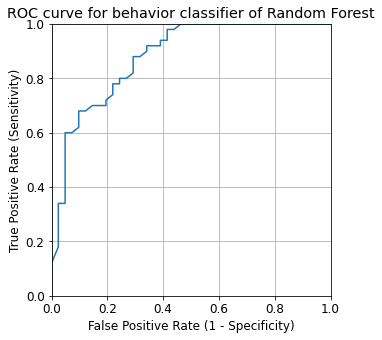


Naive Bayes

************************************************************************************************************************************************************************
kFold : 4
Accuracy for Naive Bayes : 75.82
Confusion matrix:
[[28 13]
 [ 9 41]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,9,13,28,41,0.756757,0.759259,0.240741,0.243243,0.759259,0.756757,0.682927,0.717949,0.241758,0.758242,0.758008,0.516016,0.507382


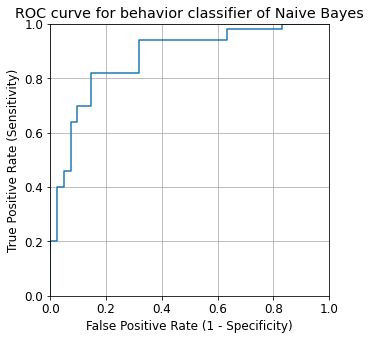


LSTM

************************************************************************************************************************************************************************
Epoch 1/5
7/7 [==============================] - 5s 15ms/step - loss: 0.9459 - accuracy: 0.5425 - auc_3: 0.5000
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.6947 - accuracy: 0.5425 - auc_3: 0.5000
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.6891 - accuracy: 0.5425 - auc_3: 0.5000
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.6911 - accuracy: 0.5425 - auc_3: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.6910 - accuracy: 0.5425 - auc_3: 0.5000
Test Accuracy for LSTM:
3/3 [==============================] - 1s 7ms/step - loss: 0.6889 - accuracy: 0.5495 - auc_3: 0.5000
[[ 0 41]
 [ 0 50]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,0,41,0,50,NaN,0.549451,0.450549,NaN,0.549451,NaN,0.0,NaN,0.450549,0.549451,NaN,NaN,0.0


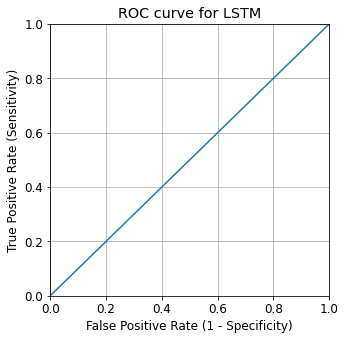

------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest

************************************************************************************************************************************************************************
kFold : 5
Accuracy for Random Forest : 82.42
Confusion matrix:
[[34  7]
 [ 9 41]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,9,7,34,41,0.790698,0.854167,0.145833,0.209302,0.854167,0.790698,0.829268,0.809524,0.175824,0.824176,0.822432,0.644864,0.64643


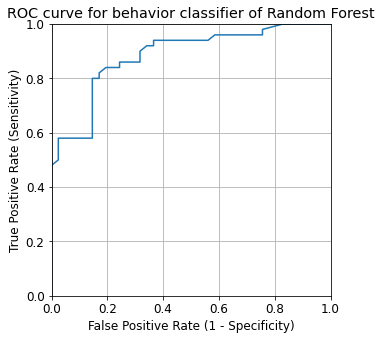


Naive Bayes

************************************************************************************************************************************************************************
kFold : 5
Accuracy for Naive Bayes : 78.02
Confusion matrix:
[[33  8]
 [12 38]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,12,8,33,38,0.733333,0.826087,0.173913,0.266667,0.826087,0.733333,0.804878,0.767442,0.21978,0.78022,0.77971,0.55942,0.559961


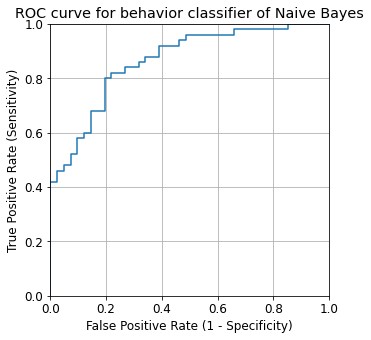


LSTM

************************************************************************************************************************************************************************
Epoch 1/5
7/7 [==============================] - 4s 16ms/step - loss: 0.9425 - accuracy: 0.5425 - auc_4: 0.5000
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.6905 - accuracy: 0.5425 - auc_4: 0.5000
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.6901 - accuracy: 0.5425 - auc_4: 0.5000
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.6898 - accuracy: 0.5425 - auc_4: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.6905 - accuracy: 0.5425 - auc_4: 0.5000
Test Accuracy for LSTM:
3/3 [==============================] - 1s 7ms/step - loss: 0.6887 - accuracy: 0.5495 - auc_4: 0.5000
[[ 0 41]
 [ 0 50]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,0,41,0,50,NaN,0.549451,0.450549,NaN,0.549451,NaN,0.0,NaN,0.450549,0.549451,NaN,NaN,0.0


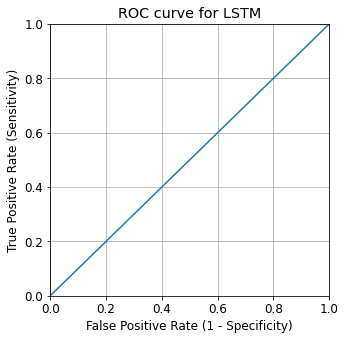

------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest

************************************************************************************************************************************************************************
kFold : 6
Accuracy for Random Forest : 81.32
Confusion matrix:
[[30 11]
 [ 6 44]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,6,11,30,44,0.833333,0.8,0.2,0.166667,0.8,0.833333,0.731707,0.779221,0.186813,0.813187,0.816667,0.633333,0.618496


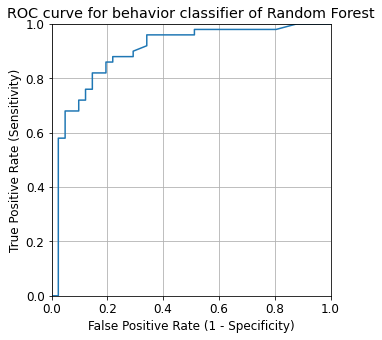


Naive Bayes

************************************************************************************************************************************************************************
kFold : 6
Accuracy for Naive Bayes : 85.71
Confusion matrix:
[[32  9]
 [ 4 46]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,4,9,32,46,0.888889,0.836364,0.163636,0.111111,0.836364,0.888889,0.780488,0.831169,0.142857,0.857143,0.862626,0.725253,0.708261


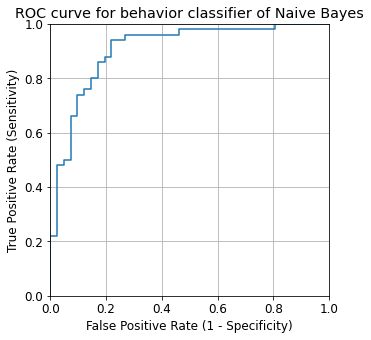


LSTM

************************************************************************************************************************************************************************
Epoch 1/5
7/7 [==============================] - 4s 16ms/step - loss: 0.8882 - accuracy: 0.5425 - auc_5: 0.5000
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.7076 - accuracy: 0.5425 - auc_5: 0.5000
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.6981 - accuracy: 0.5425 - auc_5: 0.5000
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.6859 - accuracy: 0.5425 - auc_5: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 18ms/step - loss: 0.6821 - accuracy: 0.5425 - auc_5: 0.5000
Test Accuracy for LSTM:
3/3 [==============================] - 1s 8ms/step - loss: 0.7055 - accuracy: 0.5495 - auc_5: 0.5000
[[ 0 41]
 [ 0 50]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,0,41,0,50,NaN,0.549451,0.450549,NaN,0.549451,NaN,0.0,NaN,0.450549,0.549451,NaN,NaN,0.0


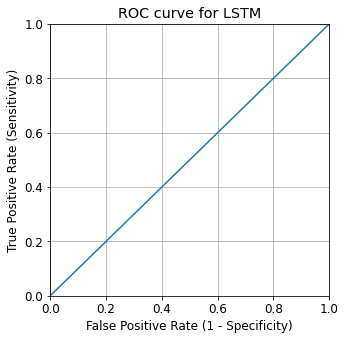

------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest

************************************************************************************************************************************************************************
kFold : 7
Accuracy for Random Forest : 83.52
Confusion matrix:
[[34  7]
 [ 8 42]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,8,7,34,42,0.809524,0.857143,0.142857,0.190476,0.857143,0.809524,0.829268,0.819277,0.164835,0.835165,0.833333,0.666667,0.667802


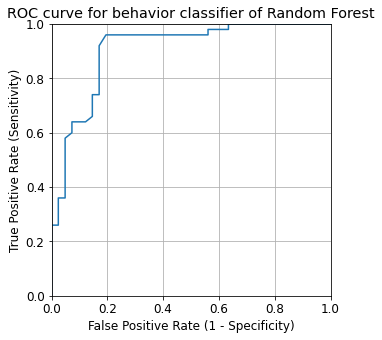


Naive Bayes

************************************************************************************************************************************************************************
kFold : 7
Accuracy for Naive Bayes : 80.22
Confusion matrix:
[[33  8]
 [10 40]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,10,8,33,40,0.767442,0.833333,0.166667,0.232558,0.833333,0.767442,0.804878,0.785714,0.197802,0.802198,0.800388,0.600775,0.602234


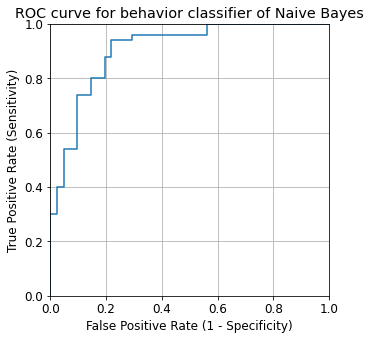


LSTM

************************************************************************************************************************************************************************
Epoch 1/5
7/7 [==============================] - 4s 16ms/step - loss: 0.9254 - accuracy: 0.5425 - auc_6: 0.5000
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.7007 - accuracy: 0.5425 - auc_6: 0.5000
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.7076 - accuracy: 0.5425 - auc_6: 0.5000
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.6899 - accuracy: 0.5425 - auc_6: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.6923 - accuracy: 0.5425 - auc_6: 0.5000
Test Accuracy for LSTM:
3/3 [==============================] - 1s 8ms/step - loss: 0.6893 - accuracy: 0.5495 - auc_6: 0.5000
[[ 0 41]
 [ 0 50]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,0,41,0,50,NaN,0.549451,0.450549,NaN,0.549451,NaN,0.0,NaN,0.450549,0.549451,NaN,NaN,0.0


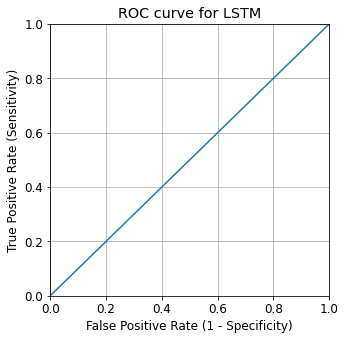

------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest

************************************************************************************************************************************************************************
kFold : 8
Accuracy for Random Forest : 82.42
Confusion matrix:
[[31 10]
 [ 6 44]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,6,10,31,44,0.837838,0.814815,0.185185,0.162162,0.814815,0.837838,0.756098,0.794872,0.175824,0.824176,0.826326,0.652653,0.641732


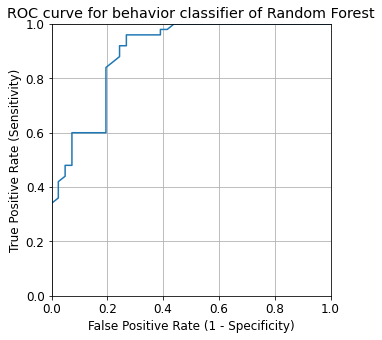


Naive Bayes

************************************************************************************************************************************************************************
kFold : 8
Accuracy for Naive Bayes : 85.71
Confusion matrix:
[[33  8]
 [ 5 45]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,5,8,33,45,0.868421,0.849057,0.150943,0.131579,0.849057,0.868421,0.804878,0.835443,0.142857,0.857143,0.858739,0.717478,0.709551


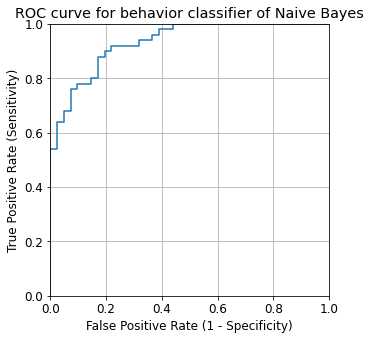


LSTM

************************************************************************************************************************************************************************
Epoch 1/5
7/7 [==============================] - 4s 16ms/step - loss: 0.8174 - accuracy: 0.5425 - auc_7: 0.5000
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.7012 - accuracy: 0.5425 - auc_7: 0.5000
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.7080 - accuracy: 0.5425 - auc_7: 0.5000
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.6879 - accuracy: 0.5425 - auc_7: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.6950 - accuracy: 0.5425 - auc_7: 0.5000
Test Accuracy for LSTM:
3/3 [==============================] - 1s 7ms/step - loss: 0.6891 - accuracy: 0.5495 - auc_7: 0.5000
[[ 0 41]
 [ 0 50]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,0,41,0,50,NaN,0.549451,0.450549,NaN,0.549451,NaN,0.0,NaN,0.450549,0.549451,NaN,NaN,0.0


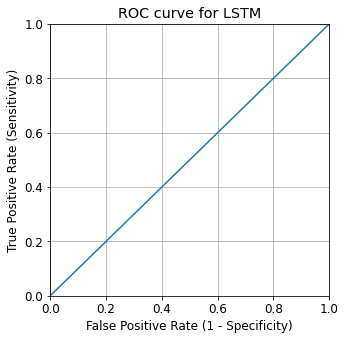

------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest

************************************************************************************************************************************************************************
kFold : 9
Accuracy for Random Forest : 80.22
Confusion matrix:
[[32  9]
 [ 9 41]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,9,9,32,41,0.780488,0.82,0.18,0.219512,0.82,0.780488,0.780488,0.780488,0.197802,0.802198,0.800244,0.600488,0.600488


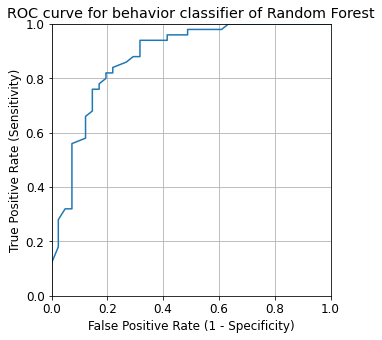


Naive Bayes

************************************************************************************************************************************************************************
kFold : 9
Accuracy for Naive Bayes : 82.42
Confusion matrix:
[[31 10]
 [ 6 44]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,6,10,31,44,0.837838,0.814815,0.185185,0.162162,0.814815,0.837838,0.756098,0.794872,0.175824,0.824176,0.826326,0.652653,0.641732


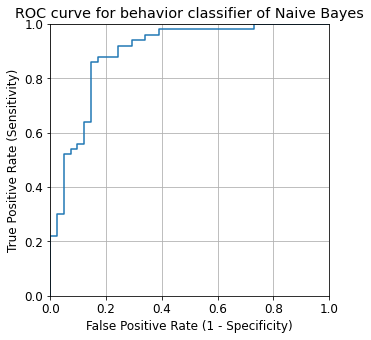


LSTM

************************************************************************************************************************************************************************
Epoch 1/5
7/7 [==============================] - 5s 16ms/step - loss: 0.9170 - accuracy: 0.5425 - auc_8: 0.5000
Epoch 2/5
7/7 [==============================] - 0s 18ms/step - loss: 0.7213 - accuracy: 0.5425 - auc_8: 0.5000
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.7148 - accuracy: 0.5425 - auc_8: 0.5000
Epoch 4/5
7/7 [==============================] - 0s 19ms/step - loss: 0.6978 - accuracy: 0.5425 - auc_8: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.6912 - accuracy: 0.5425 - auc_8: 0.5000
Test Accuracy for LSTM:
3/3 [==============================] - 1s 9ms/step - loss: 0.6891 - accuracy: 0.5495 - auc_8: 0.5000
[[ 0 41]
 [ 0 50]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,0,41,0,50,NaN,0.549451,0.450549,NaN,0.549451,NaN,0.0,NaN,0.450549,0.549451,NaN,NaN,0.0


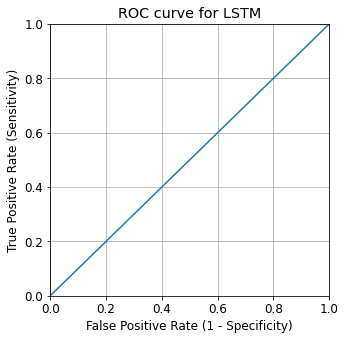

------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest

************************************************************************************************************************************************************************
kFold : 10
Accuracy for Random Forest : 86.81
Confusion matrix:
[[34  7]
 [ 5 45]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,5,7,34,45,0.871795,0.865385,0.134615,0.128205,0.865385,0.871795,0.829268,0.85,0.131868,0.868132,0.86859,0.737179,0.732484


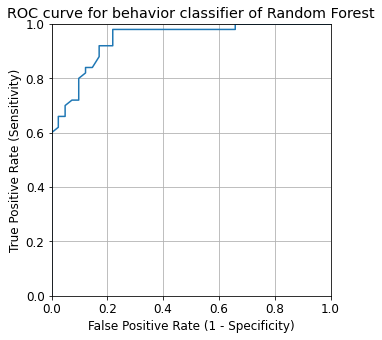


Naive Bayes

************************************************************************************************************************************************************************
kFold : 10
Accuracy for Naive Bayes : 84.62
Confusion matrix:
[[34  7]
 [ 7 43]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,7,7,34,43,0.829268,0.86,0.14,0.170732,0.86,0.829268,0.829268,0.829268,0.153846,0.846154,0.844634,0.689268,0.689268


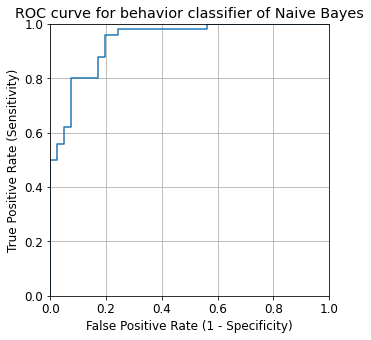


LSTM

************************************************************************************************************************************************************************
Epoch 1/5
7/7 [==============================] - 4s 16ms/step - loss: 0.9683 - accuracy: 0.5425 - auc_9: 0.5000
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.7532 - accuracy: 0.5425 - auc_9: 0.5000
Epoch 3/5
7/7 [==============================] - 0s 21ms/step - loss: 0.6961 - accuracy: 0.5425 - auc_9: 0.5000
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.6989 - accuracy: 0.5425 - auc_9: 0.5000
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.6946 - accuracy: 0.5425 - auc_9: 0.5000
Test Accuracy for LSTM:
3/3 [==============================] - 1s 9ms/step - loss: 0.6924 - accuracy: 0.5495 - auc_9: 0.5000
[[ 0 41]
 [ 0 50]]


,False negative,False positive,True positive,True negative,True positive rate,True negative rate,False positive rate,False negative rate,Specificity,Recall,Precision,F1 measure,Error rate,Accuracy,Balanced Accuracy,True Skill Statistics,Heidke Skill Score
0,0,41,0,50,NaN,0.549451,0.450549,NaN,0.549451,NaN,0.0,NaN,0.450549,0.549451,NaN,NaN,0.0


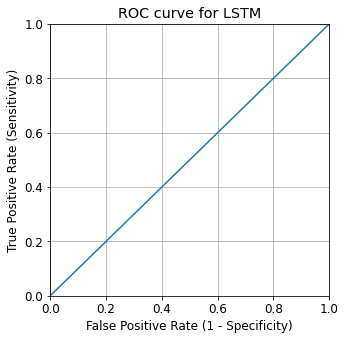

------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Mean Accuracy Score of Random Forest: 82.19780219780219
Mean Accuracy Score of Naive Bayes: 81.42857142857143
Mean Accuracy Score of LSTM: 54.94505494505494


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

rfc_total_score = 0.0
gnb_total_score = 0.0
lstm_total_score = 0.0
for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
    X_minmax_train, X_minmax_test, y_minmax_train, y_minmax_test = train_test_split(X_minmax, y, stratify=y, test_size=0.3)
    
    print('Random Forest')
    print('')
    print('************************************************************************************************************************************************************************')
    
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, y_train)
    rfc_prediction = rfc.predict(X_test)
    
    print("kFold :", i+1)
    print('Accuracy for Random Forest :', round(accuracy_score(rfc_prediction, y_test)*100,2))
    print('Confusion matrix:')
    cnf_matrix = confusion_matrix(y_test, rfc_prediction)
    print(cnf_matrix)
    
    res_df = classification_metrics(cnf_matrix)
    display(res_df)
    
    #Computing ROC and AUC
    probs_y = rfc.predict_proba(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test,probs_y[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for behavior classifier of Random Forest')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()
    rfc_total_score = rfc_total_score + accuracy_score(rfc_prediction, y_test)
    print('')


    print('Naive Bayes')
    print('')
    print('************************************************************************************************************************************************************************')
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    gnb_prediction = gnb.predict(X_test)
    
    print("kFold :", i+1)
    print('Accuracy for Naive Bayes :', round(accuracy_score(gnb_prediction, y_test)*100,2))
    print('Confusion matrix:')
    cnf_matrix = confusion_matrix(y_test, gnb_prediction)
    print(cnf_matrix)
    
    gnb_df = classification_metrics(cnf_matrix)
    display(gnb_df)
    
    #Computing ROC and AUC
    probs_y = gnb.predict_proba(X_test) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test,probs_y[:,1])
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for behavior classifier of Naive Bayes')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()

    gnb_total_score = gnb_total_score + accuracy_score(gnb_prediction, y_test)
    print('')


    print('LSTM')
    print('')
    print('************************************************************************************************************************************************************************')
    lstm_model = tf.keras.Sequential()
    lstm_model.add(tf.keras.layers.LSTM(28, return_sequences=True, return_state=False, input_shape= (X_minmax_train.shape[1], 1)))
    lstm_model.add(tf.keras.layers.LSTM(28, return_sequences=False, return_state=False))
    lstm_model.add(tf.keras.layers.Dense(1, activation='softmax'))
    # Compile the Model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', summation_method='interpolation')])
    lstm_model.fit(X_minmax_train, y_minmax_train, epochs=5)
    print('Test Accuracy for LSTM:')
    lstm_model.evaluate(X_minmax_test, y_minmax_test)
    prediction = lstm_model.predict(X_minmax_test)
    cnf_matrix = tf.math.confusion_matrix(y_minmax_test, prediction)
    print(cnf_matrix.numpy())
    lstm_df = classification_metrics(cnf_matrix.numpy())
    display(lstm_df)

    y_pred_proba = lstm_model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(y_minmax_test, y_pred_proba)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for LSTM')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()

    lstm_total_score = lstm_total_score + accuracy_score(prediction, y_minmax_test)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('')
print("Mean Accuracy Score of Random Forest:", (rfc_total_score/10)*100)
print("Mean Accuracy Score of Naive Bayes:", (gnb_total_score/10)*100)
print("Mean Accuracy Score of LSTM:", (lstm_total_score/10)*100)

# Inference 
Got the best mean accuracy score after 10 folds cross-validation for Naive bayes algorithm, followed by Random forest and least for LSTM.